## PMBPQM figures


In [ ]:
import numpy as np
from numpy import linalg as LA
import scipy
import scipy.linalg 
from google.colab import files
import matplotlib.pyplot as plt
import random

def pauli(x):
    if x==0:
        return np.array([[1,0],[0,1]])
    if x==1:
        return np.array([[0,1],[1,0]])
    if x==2:
        return np.array([[0,-1j],[+1j,0]])
    if x==3:
        return np.array([[1,0],[0,-1]])
    else:
        print('invalid')

# modified rho based on delta, gamma, and input x rather than theta and p
def rhom(delta,g,x):
  return pauli(x)@np.array([[delta, g],[g, 1-delta]])@pauli(x)

# "bitnode" take input states parameterized by (d1, g1) and (d2, g2) and returns the post-measurement state parameters and probabilities at a bitnode
def bitnode(d1,g1,d2,g2):
  # the state given root value z=0 is rho0 = np.kron(rhom(d1,g1,0),rhom(d2,g2,0))
  # the state given root value z=1 is rho1 = np.kron(rhom(d1,g1,1),rhom(d2,g2,1))
  # we find the paired measurements by taking the eigenvectors of the difference matrix rhofull
  rhofull = np.kron(rhom(d1,g1,0),rhom(d2,g2,0))-np.kron(rhom(d1,g1,1),rhom(d2,g2,1))
  evals, evecs = np.linalg.eigh(rhofull)
  # fix eigenvector v0 
  v0 = evecs[:,0]
  # symmetry operator Un = np.kron(pauli(1),pauli(1))
  Un = np.kron(pauli(1),pauli(1))
  # check if the second eigenvector evecs[:,1] is orthogonal to Un@evecs[:,1]
  x = evecs[:,1]@(Un@evecs[:,1])
  if np.abs(x)<10e-10:
    v1 = evecs[:,1]
  # if not orthogonal, combine evecs[:,1], evecs[:,2] to create v1 s.t. v1@(Un@v1)= 0
  if np.abs(x)>=10e-10:
    vec1, vec2 = evecs[:,1], evecs[:,2]
    b11, b12, b21, b22 = np.inner(vec1, (Un@vec1).conj()), np.inner(vec2, (Un@vec1).conj()), np.inner(vec1, (Un@vec2).conj()), np.inner(vec2, (Un@vec2).conj())
    alpha = (-b12-b21-np.sqrt((b12+b21)**2-4*b11*b22))/(2*b22)
    v1 = vec1+alpha*vec2
    v1 = v1/np.sqrt(v1@v1)
  # the paired measurement is then given by {|v0><v0| + Un|v0><v0|Un, |v1><v1| + Un|v1><v1|Un}
  ## find new state parameters (d1a, g1a) for measurement outcome 0
  # find probability p0 of observing measurement  outcome 0
  p0 = v0@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@v0+v0@Un@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@Un@v0
  d1a, g1a = v0@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@v0/(p0+10e-21), v0@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@(Un@v0)/(p0+10e-21)
  ## find new state parameters (d1b, g1b) for measurement outcome 1
  # find probability p1 of observing measurement  outcome 1  
  p1 = v1@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@v1+v1@Un@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@Un@v1
  d2a, g2a = v1@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@v1/(p1+10e-21), v1@np.kron(rhom(d1,g1,0),rhom(d2,g2,0))@(Un@v1)/(p1+10e-21)
  return np.array([[d1a, g1a], [d2a, g2a]]), np.array([p0, p1])

# "checknode" take input states parameterized by (d1, g1) and (d2, g2) and returns the post-measurement state parameters and probabilities at a checknode
def checknode(d1,g1,d2,g2):
  # rho0, rho1 correspond to the states at a check node when z=0 (z=1) respectively
  rho0, rho1 = 1/2*(np.kron(rhom(d1,g1,0),rhom(d2,g2,0)) + np.kron(rhom(d1,g1,1),rhom(d2,g2,1))), 1/2*(np.kron(rhom(d1,g1,0),rhom(d2,g2,1)) + np.kron(rhom(d1,g1,1),rhom(d2,g2,0)))
  # for check node combining, the optimal choice of eigenvectors appears to always be generated by v0 and v1
  v0 = 1/np.sqrt(2)*np.array([1,0,0,1])
  v1 = 1/np.sqrt(2)*np.array([-1, 0, 0, 1])
  # symmetry operator for a check node
  Un = np.kron(pauli(1),pauli(0))
  ## find new state parameters (d1a, g1a) for measurement outcome 0
  # find probability p0 of observing measurement  outcome 0
  p0 = v0@rho0@v0+v0@Un@rho0@Un@v0
  d1a, g1a = v0@rho0@v0/(p0+10e-21), v0@rho0@(Un@v0)/(p0+10e-21)
  ## find new gamma, delta for second outcome
  p1 = v1@rho0@v1+v1@Un@rho0@Un@v1
  d2a, g2a = v1@rho0@v1/(p1+10e-21), v1@rho0@(Un@v1)/(p1+10e-21)
  # return new gamma, delta pairs as well as respective probabilities tra and tr2a
  return np.array([[d1a, g1a], [d2a, g2a]]), np.array([p0, p1])

H = 1/np.sqrt(2)*np.array([[1,-1],[1,1]])
sgz = np.array([[1,0],[0,-1]])
sgx = np.array([[0,1],[1,0]])
 
# pure state channel outputs
def rho(th):
  return H@np.array([[np.cos(th/2)**2, np.cos(th/2)*np.sin(th/2)],
                   [np.cos(th/2)*np.sin(th/2), np.sin(th/2)**2]])@np.transpose(H)

# output of the channel given input z, parameter th, and flip parameter p
def W(z,th,p):
  if z == 0:
    return (1-p)*rho(th)+p*sgx@rho(th)@sgx
  if z == 1:
    return (1-p)*sgx@rho(th)@sgx+p*rho(th)

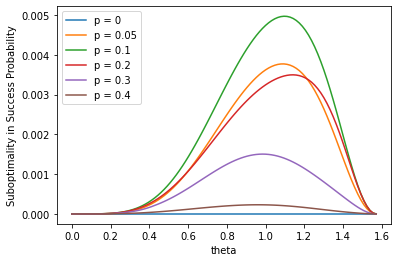

In [ ]:
# Helstrom success for the 5 qubit factor graph
def hels(th, p):
  # reduced density matrix for top qubit
  r0, r1 = W(0,th,p), W(1,th,p)
  # density matrix for qubits 23, 45 respectively
  r0q23, r1q23 = 1/2*(np.kron(r0, r0)+np.kron(r1, r1)), 1/2*(np.kron(r0, r1)+np.kron(r1, r0))
  r0q45, r1q45 = 1/2*(np.kron(r0, r0)+np.kron(r1, r1)), 1/2*(np.kron(r0, r1)+np.kron(r1, r0))
  r0tot, r1tot = np.kron(r0, np.kron(r0q23, r0q45)), np.kron(r1, np.kron(r1q23, r1q45))
  eval, _ = np.linalg.eigh(r0tot-r1tot)
  return 1/2+1/4*np.sum(np.abs(eval))

# BPQM for 5 qubit factor graph
def fBPQM(th, p):
  psucc = 0
  rho0in = (1-p)*H@np.array([[np.cos(th/2)**2, np.cos(th/2)*np.sin(th/2)],
                   [np.cos(th/2)*np.sin(th/2), np.sin(th/2)**2]])@np.transpose(H) + p*sgx@H@np.array([[np.cos(th/2)**2, np.cos(th/2)*np.sin(th/2)],
                   [np.cos(th/2)*np.sin(th/2), np.sin(th/2)**2]])@np.transpose(H)@sgx 
  delta, gamma = rho0in[0][0], rho0in[0][1]
  # check node for qubits 4,5
  delset45, pset45 = checknode(delta,gamma,delta,gamma)
  for j in range(2):
      dg_q4t = delset45[j]
      proundA = pset45[j]
      #bit node for post-measurement state (from 4,5) with qubit 1
      delset1t, pset1t = bitnode(dg_q4t[0],dg_q4t[1],delta,gamma)
      #check node for qubits 2,3
      delset23, pset23 = checknode(delta,gamma,delta,gamma)
      for l in range(2):
        for m in range(2):
          if pset23[l]*pset1t[m]>10e-10:
            proundB = proundA*pset23[l]*pset1t[m]
            dg_q2t, dg_q1t = delset23[l], delset1t[m]
            # combine post-measurement qubit from (2,3) with post-measurement qubit from (1,4,5)
            rho0tot, rho1tot = np.kron(rhom(dg_q1t[0], dg_q1t[1], 0), rhom(dg_q2t[0], dg_q2t[1], 0)), np.kron(rhom(dg_q1t[0], dg_q1t[1], 1), rhom(dg_q2t[0], dg_q2t[1], 1))
            evals, _ = scipy.linalg.eig(rho0tot-rho1tot)
            psucc = psucc + proundB*(1/2+1/4*np.sum(np.abs(evals)))
  return np.real(psucc)


thvec = np.linspace(0, np.pi/2, 100)

diffvec1 = np.array([hels(th, 0) for th in thvec]) - np.array([fBPQM(th, 0) for th in thvec])
diffvec2 = np.array([hels(th, 0.05) for th in thvec]) - np.array([fBPQM(th, 0.05) for th in thvec])
diffvec3 = np.array([hels(th, 0.1) for th in thvec]) - np.array([fBPQM(th, 0.1) for th in thvec])
diffvec4 = np.array([hels(th, 0.2) for th in thvec]) - np.array([fBPQM(th, 0.2) for th in thvec])
diffvec5 = np.array([hels(th, 0.3) for th in thvec]) - np.array([fBPQM(th, 0.3) for th in thvec])
diffvec6 = np.array([hels(th, 0.4) for th in thvec]) - np.array([fBPQM(th, 0.4) for th in thvec])


import matplotlib.pyplot as plt


# Plot difference between Helstorm and PMBPQM
plt.plot(thvec, diffvec1/np.array([hels(th, 0) for th in thvec]), label = "p = 0")
plt.plot(thvec, diffvec2/np.array([hels(th, 0.05) for th in thvec]), label = "p = 0.05")
plt.plot(thvec, diffvec3/np.array([hels(th, 0.1) for th in thvec]), label = "p = 0.1")
plt.plot(thvec, diffvec4/np.array([hels(th, 0.2) for th in thvec]), label = "p = 0.2")
plt.plot(thvec, diffvec5/np.array([hels(th, 0.3) for th in thvec]), label = "p = 0.3")
plt.plot(thvec, diffvec6/np.array([hels(th, 0.4) for th in thvec]), label = "p = 0.4")

plt.ylabel("Suboptimality in Success Probability")
plt.xlabel("theta")
plt.legend()
plt.show()

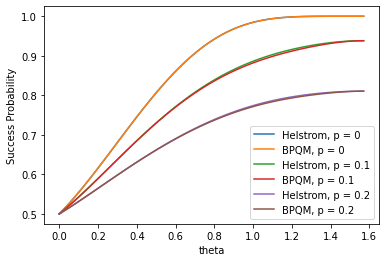

In [ ]:
# Plot Helstrom and PMBPQM together

hels1 = np.array([hels(th, 0) for th in thvec])
hels3 = np.array([hels(th, 0.1) for th in thvec]) 
hels5 = np.array([hels(th, 0.2) for th in thvec]) 
###
BPQM1 = np.array([fBPQM(th, 0) for th in thvec])
BPQM3 = np.array([fBPQM(th, 0.1) for th in thvec])
BPQM5 = np.array([fBPQM(th, 0.2) for th in thvec])

##

plt.plot(thvec, hels1, label = "Helstrom, p = 0")
plt.plot(thvec, BPQM1, label = "BPQM, p = 0")
plt.plot(thvec, hels3, label = "Helstrom, p = 0.1")
plt.plot(thvec, BPQM3, label = "BPQM, p = 0.1")
plt.plot(thvec, hels5, label = "Helstrom, p = 0.2")
plt.plot(thvec, BPQM5, label =  "BPQM, p = 0.2")
plt.ylabel("Success Probability")
plt.xlabel("theta")
plt.legend()
plt.show()

# Locally Greedy Algorithm

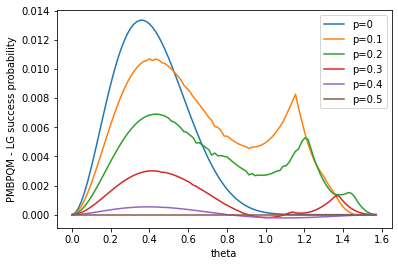

In [ ]:
import copy
# Locally Greedy method for 7 qubit factor graph


# first need to define Helstrom measurement with prior included
# first need to define Helstrom measurement with prior included

def helsmeas(rho0, rho1, q):
  eval, evec = np.linalg.eigh(q*rho0-(1-q)*rho1)
  #Pi = np.zeros((4,4))
  qup = []
  prob = []
  for _ in range(len(eval)):
      Pi = np.outer(evec[:,_], evec[:,_])
      qup.append(q*np.trace(Pi@rho0)/(q*np.trace(Pi@rho0)+(1-q)*np.trace(Pi@rho1)+10e-20))
      prob.append(q*np.trace(Pi@rho0)+(1-q)*np.trace(Pi@rho1))
  return prob, qup

# BPQM for seven qubit factor graph
def fBPQM(th, p):
  psucc = 0
  rho0in = (1-p)*H@np.array([[np.cos(th/2)**2, np.cos(th/2)*np.sin(th/2)],
                   [np.cos(th/2)*np.sin(th/2), np.sin(th/2)**2]])@np.transpose(H) + p*sgx@H@np.array([[np.cos(th/2)**2, np.cos(th/2)*np.sin(th/2)],
                   [np.cos(th/2)*np.sin(th/2), np.sin(th/2)**2]])@np.transpose(H)@sgx 
  delta, gamma = rho0in[0][0], rho0in[0][1]
  delset45, pset45 = checknode(delta,gamma,delta,gamma)
  # qubits 6,7
  delset67, pset67 = bitnode(delta,gamma,delta,gamma)
  for j in range(2):
    for k in range(2):
      dg_q4t = delset45[j]
      dg_q6t = delset67[k]
      proundA = pset45[j]*pset67[k]
      #combine 4t and 1
      delset1t, pset1t = bitnode(dg_q4t[0],dg_q4t[1],delta,gamma)
      #combine 6t and 2
      delset2t, pset2t = bitnode(dg_q6t[0],dg_q6t[1],delta,gamma)
      for l in range(2):
        for m in range(2):
          if pset2t[m]*pset1t[l]>10e-15:
            proundB = proundA*pset2t[m]*pset1t[l]
            dg_q1t, dg_q2t = delset1t[l], delset2t[m]
            #check node for 2t and 3
            delset3t, pset3t = checknode(dg_q2t[0], dg_q2t[1], delta, gamma)
            for n in range(2):
              if pset3t[n]>10e-15:
                dg_q3t = delset3t[n]
                proundC = pset3t[n]*proundB
                rho0tot, rho1tot = np.kron(rhom(dg_q1t[0], dg_q1t[1], 0), rhom(dg_q3t[0], dg_q3t[1], 0)), np.kron(rhom(dg_q1t[0], dg_q1t[1], 1), rhom(dg_q3t[0], dg_q3t[1], 1))
                evals, _ = scipy.linalg.eig(rho0tot-rho1tot)
                psucc = psucc + proundC*(1/2+1/4*np.sum(np.abs(evals)))
  return np.real(psucc)


# now define LG method for 7-qubit factor graph with given theta, p

def LG(th, p):
  psucc = 0
  q = 1/2
  # qubits 6,7
  r0, r1 = W(0,th,p), W(1,th,p)
  probs67, qupvec67 = helsmeas(np.kron(r0, r0), np.kron(r1, r1), q)
  for j in range(4):
    pr67, qup67 = probs67[j], qupvec67[j]
    # qubits 4,5
    r0, r1 = W(0,th,p), W(1,th,p)
    r0q45, r1q45 = qup67*np.kron(r0, r0)+(1-qup67)*np.kron(r1, r1), qup67*np.kron(r0, r1)+(1-qup67)*np.kron(r1, r0)
    probs45, qupvec45 = helsmeas(r0q45, r1q45, 1/2)
    for k in range(4):
      pr4567, qup4567 = pr67*probs45[k], qupvec45[k]
      #qubits 2,3
      r0, r1 = W(0,th,p), W(1,th,p)
      r0q23, r1q23 = 1/2*(np.kron(r0, r0)+np.kron(r1, r1)), 1/2*(np.kron(r0, r1)+np.kron(r1, r0))
      probs23, qupvec23 = helsmeas(r0q23, r1q23, qup4567)
      for l in range(4):
        pr234567, qup234567 = pr4567*probs23[l], qupvec23[l]
        r0, r1 = W(0,th,p), W(1,th,p)
        evals, _ = np.linalg.eigh(qup234567*r0-(1-qup234567)*r1)
        psucc = psucc + pr234567*(1/2+1/2*sum(abs(evals)))
  return psucc

# plot the difference between PMBPQM and the locally greedy approach
thvec = np.linspace(0, np.pi/2, 99)
diffarr0 = np.array([fBPQM(th,0)-LG(th,0) for th in thvec])
diffarr = np.array([fBPQM(th,0.1)-LG(th,0.1) for th in thvec])
diffarr2 = np.array([fBPQM(th,0.2)-LG(th,0.2) for th in thvec])
diffarr3 = np.array([fBPQM(th,0.3)-LG(th,0.3) for th in thvec])
diffarr4 = np.array([fBPQM(th,0.4)-LG(th,0.4) for th in thvec])
diffarr5 = np.array([fBPQM(th,0.5)-LG(th,0.5) for th in thvec])

plt.plot(thvec, diffarr0, label = "p=0")
plt.plot(thvec, diffarr, label = "p=0.1")
plt.plot(thvec, diffarr2, label = "p=0.2")
plt.plot(thvec, diffarr3, label = "p=0.3")
plt.plot(thvec, diffarr4, label = "p=0.4")
plt.plot(thvec, diffarr5, label = "p=0.5")

plt.xlabel("theta")
plt.ylabel("PMBPQM - LG success probability")
plt.legend()
plt.show()

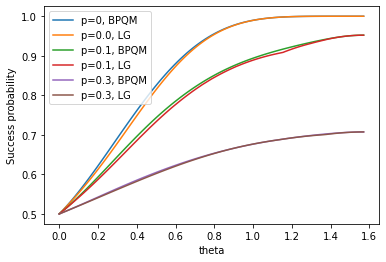

In [ ]:
# plot the difference between PMBPQM and the locally greedy approach


BPQM0 = np.array([fBPQM(th,0) for th in thvec])
LG0 = np.array([LG(th,0) for th in thvec])
##
BPQM01 = np.array([fBPQM(th,0.1) for th in thvec])
LG01 = np.array([LG(th,0.1) for th in thvec])
##
BPQM03 = np.array([fBPQM(th,0.3) for th in thvec])
LG03 = np.array([LG(th,0.3) for th in thvec])


plt.plot(thvec, BPQM0, label = "p=0, BPQM")
plt.plot(thvec, LG0, label = "p=0.0, LG")
plt.plot(thvec, BPQM01, label = "p=0.1, BPQM")
plt.plot(thvec, LG01, label = "p=0.1, LG")
plt.plot(thvec, BPQM03, label = "p=0.3, BPQM")
plt.plot(thvec, LG03, label = "p=0.3, LG")

plt.xlabel("theta")
plt.ylabel("Success probability")
plt.legend()
plt.show()

## Figure 3- Density Evolution

In [ ]:
import numpy as np
# bitcomb takes two qubits at a bitnode parametrized by (d0, g0) and (g1, d1) and generates a new post-measurement qubit with parameters set12 = (g'', d'')
def bitcomb(d0, g0, d1, g1):
  dgset, probs = bitnode(d0, g0, d1, g1)
  out1 = np.random.choice(np.arange(0, 2), p=[np.abs(np.round(probs[0], 7)), 1-np.abs(np.round(probs[0], 7))])
  # new index ind12
  set12 = dgset[out1]
  return set12

# checkcomb takes two qubits at a checknode parametrized by (g0, d0) and (g1, d1) and generates a new post-measurement qubit with parameters set12 = (g'', d'')
def checkcomb(d0, g0, d1, g1):
  dgset, probs = checknode(d0, g0, d1, g1)
  out1 = np.random.choice(np.arange(0, 2), p=[np.abs(np.round(probs[0], 7)), 1-np.abs(np.round(probs[0], 7))])
  # new index ind12
  set12 = dgset[out1]
  return set12


# Consider code where bit nodes have degree 3, check nodes have degree CNd, bit node has degree BNd
# Given starting set of channel parameters (set1) with N different qubits, iters is the number of rounds of check and bit node combining
# (dstart, gstart) are the channel parameters of the initial channel all qubits are sent through 
def set_update(set1, N, iters, dstart, gstart, BNd, CNd):
  set2 = set1
  for _ in range(iters):
    set1 = set2
    set2 = []
    ## bit node combining for even iterations
    if _%2==0:
      for j in range(N):
        # randonly draw indices for qubits 1, 2
        ind1, ind2, ind3 = random.randint(0, N-1), random.randint(0, N-1), random.randint(0, N-1)
        # first we combine ind1 and ind2
        set12 = bitcomb(set1[ind1][0], set1[ind1][1],set1[ind2][0], set1[ind2][1])
        #if degree 4, combine set12 with qubit 3
        if BNd==4:
          set12 = bitcomb(set12[0], set12[1], set1[ind3][0], set1[ind3][1])
        # now we combine the post-measurement qubit with the top qubit
        ### finally we combine with the top qubit
        set2.append(bitcomb(set12[0], set12[1],dstart, gstart))
    ## check node combining for odd iterations
    if _%2 == 1:
      for j in range(N):
        # randomly draw indices for qubits 1, 2, 3, 4, 5, 6
        ind1, ind2, ind3, ind4, ind5, ind6 = np.array([random.randint(0, N-1) for _ in range(6)])
        # first we combine qubits 1 and 2
        set12 = checkcomb(set1[ind1][0], set1[ind1][1],set1[ind2][0], set1[ind2][1])
        # then combine qubits 3 and (1,2))
        setn = checkcomb(set1[ind3][0], set1[ind3][1],set12[0], set12[1])
        if CNd == 5 or CNd==6:
          setn = checkcomb(set1[ind4][0], set1[ind4][1],setn[0], setn[1])
        if CNd==6:
          setn = checkcomb(set1[ind5][0], set1[ind5][1],setn[0], setn[1])
        # append
        set2.append(setn)
  return set2

      
def PSC_histp_HD(th, p, N, iter, BNd, CNd):
   d1, g1 = (1-p)*1/2*(1+np.sin(th))+p/2, (1-p)*np.cos(th)/2
   dstart, gstart = (1-p)*1/2*(1+np.sin(th))+p/2, (1-p)*np.cos(th)/2
   set1 = np.array([[d1, g1] for _ in range(N)])
   st = set_update(set1, N, iter, dstart, gstart, BNd, CNd)
   pvec = []
   for _ in range(N):
     rhodiff = np.array([[st[_][0], st[_][1]],[st[_][1], 1-st[_][0]]]) - sgx@np.array([[st[_][0], st[_][1]],[st[_][1], 1-st[_][0]]])@sgx
     evals, _ = np.linalg.eigh(rhodiff)
     ps = 1/2+1/4*np.sum(np.abs(evals))
     pvec.append(ps)
   return pvec

# implement binary search
def binarysearch_HD(th, iter, eps1, tol, BNd, CNd):
  p, step = 1/2, 1/2
  pthresh, done = -1, False
  while done == False:
    pvec = PSC_histp_HD(th, p, 1750, iter, BNd, CNd)
    step = step*1/2
    if np.mean(pvec) < 1 - eps1:
      p = p - step
    if np.mean(pvec) >= 1 - eps1:
      pthresh = p
      p = p + step
    if step < tol:
      done = True
  return pthresh

# find running mean of array x
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
    np.convolve(x, np.ones(N)/N, mode='valid')

In [ ]:
# generate plot for the (3,4) LDPC code

# quantize theta and find corresponding p threshold (via binarysearch_HD)
thvec = np.linspace(0.4, np.pi/2, 10)
threshvec34 = []
for _ in range(len(thvec)):
    thresh = binarysearch_HD(thvec[_], 10, 0.03, 0.005, 3, 4)
    print("th")
    print(thvec[_])
    threshvec34.append(thresh)
    print("threshvec")
    print(threshvec34)

#note- to replicate the image in the paper, replace the above with the following (with a longer runtime)

# thvec = np.linspace(0.4, np.pi/2, 50)
# threshvec34 = []
# for _ in range(len(thvec)):
#     thresh = binarysearch_HD(thvec[_], 25, 0.01, 0.005, 3, 4)
#     print("th")
#     print(thvec[_])
#     threshvec34.append(thresh)
#     print("threshvec")
#     print(threshvec34)


th
0.4
threshvec
[-1]
th
0.5300884807549886
threshvec
[-1, -1]
th
0.6601769615099771
threshvec
[-1, -1, -1]
th
0.7902654422649655
threshvec
[-1, -1, -1, 0.0390625]
th
0.9203539230199541
threshvec
[-1, -1, -1, 0.0390625, 0.09375]
th
1.0504424037749427
threshvec
[-1, -1, -1, 0.0390625, 0.09375, 0.1484375]
th
1.1805308845299312
threshvec
[-1, -1, -1, 0.0390625, 0.09375, 0.1484375, 0.1953125]
th
1.3106193652849196
threshvec
[-1, -1, -1, 0.0390625, 0.09375, 0.1484375, 0.1953125, 0.25]
th
1.440707846039908
threshvec
[-1, -1, -1, 0.0390625, 0.09375, 0.1484375, 0.1953125, 0.25, 0.265625]
th
1.5707963267948966
threshvec
[-1, -1, -1, 0.0390625, 0.09375, 0.1484375, 0.1953125, 0.25, 0.265625, 0.2734375]


In [ ]:
threshvec34 = [-1, -1, -1, 0.0390625, 0.09375, 0.1484375, 0.1953125, 0.25, 0.265625, 0.2734375]

In [ ]:
# generate plot for the (4,5) LDPC code

# quantize theta and find corresponding p threshold (via binarysearch_HD)
thvec = np.linspace(0.4, np.pi/2, 10)
threshvec45 = []
for _ in range(len(thvec)):
    thresh = binarysearch_HD(thvec[_], 10, 0.03, 0.005, 4, 5)
    print("th")
    print(thvec[_])
    threshvec45.append(thresh)
    print("threshvec")
    print(threshvec45)

#note- to replicate the image in the paper, replace the above with the following (with a longer runtime)

# thvec = np.linspace(0.4, np.pi/2, 50)
# threshvec45 = []
# for _ in range(len(thvec)):
#     thresh = binarysearch_HD(thvec[_], 25, 0.01, 0.005, 4, 5)
#     print("th")
#     print(thvec[_])
#     threshvec45.append(thresh)
#     print("threshvec")
#     print(threshvec45)

th
0.4
threshvec
[-1]
th
0.5300884807549886
threshvec
[-1, -1]
th
0.6601769615099771
threshvec
[-1, -1, 0.03125]
th
0.7902654422649655
threshvec
[-1, -1, 0.03125, 0.09375]
th
0.9203539230199541
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625]
th
1.0504424037749427
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625]
th
1.1805308845299312
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625, 0.2890625]
th
1.3106193652849196
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625, 0.2890625, 0.328125]
th
1.440707846039908
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625, 0.2890625, 0.328125, 0.34375]
th
1.5707963267948966
threshvec
[-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625, 0.2890625, 0.328125, 0.34375, 0.3515625]


In [ ]:
threshvec45 = [-1, -1, 0.03125, 0.09375, 0.1640625, 0.2265625, 0.2890625, 0.328125, 0.34375, 0.3515625]
thvec = np.linspace(0.4, np.pi/2, 10)

In [ ]:
# generate plot for the (3,6) LDPC code

# quantize theta and find corresponding p threshold (via binarysearch_HD)
thvec = np.linspace(0.4, np.pi/2, 10)
threshvec36 = []
for _ in range(len(thvec)):
    thresh = binarysearch_HD(thvec[_], 10, 0.03, 0.005, 3, 6)
    print("th")
    print(thvec[_])
    threshvec36.append(thresh)
    print("threshvec")
    print(threshvec36)

#note- to replicate the image in the paper, replace the above with the following (with a longer runtime)

# thvec = np.linspace(0.4, np.pi/2, 50)
# threshvec36 = []
# for _ in range(len(thvec)):
#     thresh = binarysearch_HD(thvec[_], 25, 0.01, 0.005, 3, 6)
#     print("th")
#     print(thvec[_])
#     threshvec36.append(thresh)
#     print("threshvec")
#     print(threshvec36)

th
0.4
threshvec
[-1]
th
0.5300884807549886
threshvec
[-1, -1]
th
0.6601769615099771
threshvec
[-1, -1, -1]
th
0.7902654422649655
threshvec
[-1, -1, -1, -1]
th
0.9203539230199541
threshvec
[-1, -1, -1, -1, 0.015625]
th
1.0504424037749427
threshvec
[-1, -1, -1, -1, 0.015625, 0.046875]
th
1.1805308845299312
threshvec
[-1, -1, -1, -1, 0.015625, 0.046875, 0.09375]
th
1.3106193652849196
threshvec
[-1, -1, -1, -1, 0.015625, 0.046875, 0.09375, 0.140625]
th
1.440707846039908
threshvec
[-1, -1, -1, -1, 0.015625, 0.046875, 0.09375, 0.140625, 0.15625]
th
1.5707963267948966
threshvec
[-1, -1, -1, -1, 0.015625, 0.046875, 0.09375, 0.140625, 0.15625, 0.1640625]


In [ ]:
threshvec36 = [-1, -1, -1, -1, 0.015625, 0.046875, 0.09375, 0.140625, 0.15625, 0.1640625]

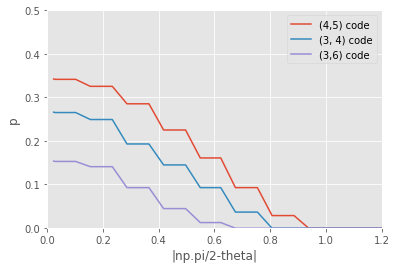

In [ ]:
# for a given (theta, p) return 0 if p is worse than the threshold and 1 else
def c0(th, p, threshvec):
  if th<thvec[0]:
    nmth= 0
  if th>=thvec[-1]:
    nmth = len(thvec)-1
  if th>=thvec[0] and th<thvec[-1]:
    for j in range(len(thvec)):
      if thvec[j]<= th:
        nmth = j
  if p>=threshvec[nmth]:
    return 0
  if p<threshvec[nmth]:
    return 1

thlist = np.linspace(0.4, np.pi/2, 100)
plist = np.linspace(0, 0.7, 100)

def createline(thvec,pvec,threshvec):
  arr = []
  for th in thvec:
    pthr = -0.001
    for p in pvec: 
      if c0(th, p,threshvec)>=1:
          pthr = p
    arr.append(pthr)
  return arr

ar2 = createline(np.linspace(0, np.pi/2, 300), np.linspace(0, 1, 250), threshvec45)
ar1 = createline(np.linspace(0, np.pi/2, 300), np.linspace(0, 1, 250), threshvec34)
ar0 = createline(np.linspace(0, np.pi/2, 300), np.linspace(0, 1, 250), threshvec36)

ln = len(running_mean( np.linspace(0, np.pi/2, 300),10))
plt.style.use("ggplot")
plt.plot(np.pi/2*np.ones(ln)- running_mean( np.linspace(0, np.pi/2, 300),10), running_mean(ar2, 10), label = "(4,5) code")
plt.plot(np.pi/2*np.ones(ln)- running_mean( np.linspace(0, np.pi/2, 300),10), running_mean(ar1, 10), label = "(3, 4) code")
plt.plot(np.pi/2*np.ones(ln)- running_mean( np.linspace(0, np.pi/2, 300),10), running_mean(ar0, 10), label = "(3,6) code")
plt.ylim([0, 0.5])
plt.xlim([0, 1.2])
plt.legend()
plt.xlabel("|np.pi/2-theta|")
plt.ylabel("p")
plt.show()


## Figure 3b- Holevo Bound Plot

In [ ]:
def rhom(delta,g,x):
  return pauli(x)@np.array([[delta, g],[g, 1-delta]])@pauli(x)


def rhop(p, th, x):
  return rhom((1-p)*1/2*(1+np.sin(th))+p/2, (1-p)*np.cos(th)/2, x)

#von Neumann entropy of density matrix
def ent(matr):
  evals, evec = np.linalg.eigh(matr)
  sum = 0
  for _ in range(2):
    if evals[_]>0:
      sum = sum + evals[_]*np.log2(1/evals[_])
  return sum

# holevo information of the channel
def hol(p, th):
  rhocomb = 1/2*rhop(p, th, 0) + 1/2*rhop(p, th, 1)
  return ent(rhocomb) - 1/2*ent(rhop(p, th, 0)) - 1/2*ent(rhop(p, th, 1))

# for a fixed th and error tolerance (tol),
# find maximal p (pthresh) such that holevo information is above the threshold
def holevo_search(th, tol, thresh):
  p, step = 1/2, 1/2
  pthresh, done = -1, False
  while done == False:
    hval = hol(p, th)
    step = step*1/2
    if hval < thresh:
      p = p - step
    if hval >= thresh:
      pthresh = p
      p = p + step
    if step < tol:
      done = True
  return pthresh

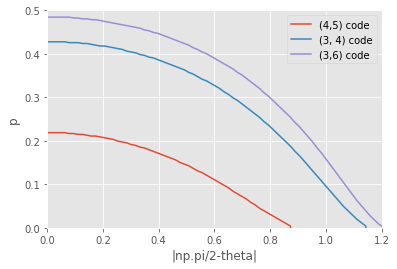

In [ ]:
#compute holevo bounds for code rates 1/5, 1/4, and 1/2
thvec = np.linspace(0, np.pi/2, 100)
holvec20 = np.array([holevo_search(thvec[_], 0.001, 0.20) for _ in range(len(thvec))])
holvec25 = np.array([holevo_search(thvec[_], 0.001, 0.25) for _ in range(len(thvec))])
holvec50 = np.array([holevo_search(thvec[_], 0.001, 0.5) for _ in range(len(thvec))])

ln = len(thvec)
plt.style.use("ggplot")
plt.plot(np.pi/2*np.ones(ln)- thvec, holvec50, label = "(4,5) code")
plt.plot(np.pi/2*np.ones(ln)- thvec, holvec25, label = "(3, 4) code")
plt.plot(np.pi/2*np.ones(ln)- thvec, holvec20, label = "(3,6) code")
plt.ylim([0, 0.5])
plt.xlim([0, 1.2])
plt.legend()
plt.xlabel("|np.pi/2-theta|")
plt.ylabel("p")
plt.show()
